# Noise Reduction 

***
***

## Import Modules

In [377]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.reset()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [378]:
import importlib
import Arduino_NoiseReduction_Code as NR

In [379]:
importlib.reload(NR)

<module 'Arduino_NoiseReduction_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\Arduino_NoiseReduction_Code.py'>

## Fit Functions

In [380]:
####### LINEAR FUCTION
def lin(x, a, b):  
    return a + b * x

####### EXPONENTIAL FUCTION
def esp(x, a, b, c):  
    return a + b * np.exp(- x * c**-1)

## Arduino Calibration

### Choose the right calibration function:

Since the signal we are going to acquire with Arduino has an amplitude between 300mV and 400mV we choose not to consider high tension inputs for the calibration. Higher tension inputs have a totally different trend: we will use them (and only them) if we find an high tension signal to acquire.

In [381]:
# READ DATA
data_low = NR.arduino_calib_read_low()

# ERROR PROPAGATION
data_low['err Vin'] = NR.propagazione_cursori(data_low['Vdiv'], data_low['Vin'])

# PERFORM THE FIT
par, cov = curve_fit(f = lin, xdata = data_low['max_values'], ydata = data_low['Vin'])

# GET FIT PARAMETERS AND PARAMETER ERRORS
error = []
for i in range(len(par)):
    try:
        error.append(np.absolute(cov[i][i])**0.5)
    except:
        error.append( 0.00 )
fit_par = par
fit_err = np.array(error)
arduino_calib_offset = fit_par[0]
arduino_calib_slope = fit_par[1]
arduino_calib_offset_err = fit_err[0]
arduino_calib_slope_err = fit_err[1]

# PRINT CALIBRATION FUNCTION
print(
        'VOLT = ' +  ' (' + format(arduino_calib_offset, '.3f') + ' +/- ' + format(arduino_calib_offset_err, '.3f') + ') ' + ' + ' 
        + ' (' + format(arduino_calib_slope, '.6f') + ' +/- ' + format(arduino_calib_slope_err, '.6f') + ') ' + ' ADC'
    )


VOLT =  (-0.637 +/- 0.010)  +  (0.000828 +/- 0.000007)  ADC


## Check the Waveform acquired

In [454]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = arduino_calib_offset + arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(arduino_calib_offset_err**2 + arduino_calib_slope_err**2)

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

# PRINT DATA
data_peek

,time,ADC,time (ms),V (V),err V (V)
287,287,1237,0.300524,0.388095,0.009805
288,288,1233,0.301571,0.384782,0.009805
289,289,1231,0.302618,0.383125,0.009805
290,290,1231,0.303665,0.383125,0.009805
291,291,1226,0.304712,0.378983,0.009805
...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805
1196,1196,789,1.252356,0.017007,0.009805
1197,1197,790,1.253403,0.017835,0.009805
1198,1198,789,1.254450,0.017007,0.009805


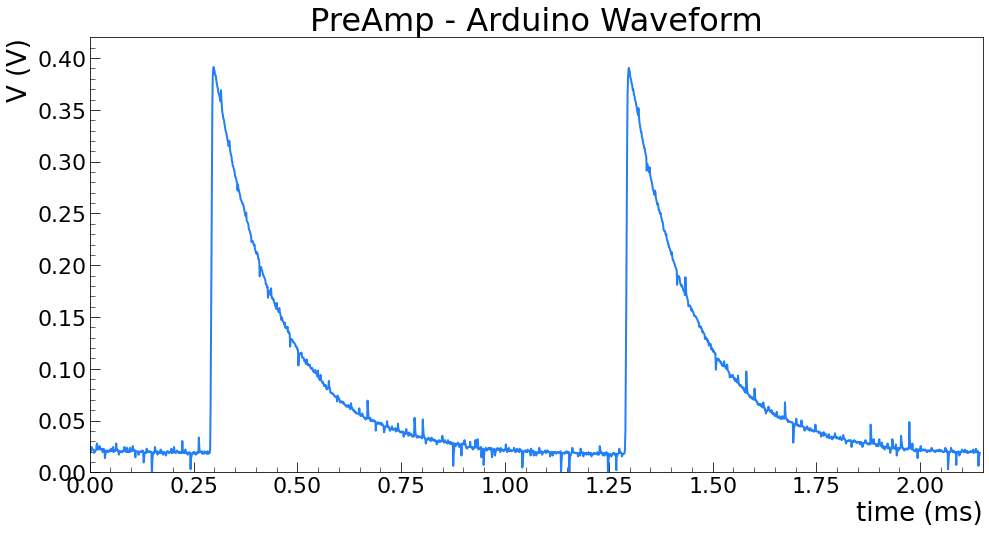

In [383]:
# PLOT DATA
NR.arduino_waveform(data)

As we can see data is a bit noisy, especially the lower tension range between 0 and 100mV

## Noise Reduction: 1st attempt

### Apply an IIR filter to data

In [384]:
import scipy.signal as signal

Here we set up the IIR filter by choosing manually the parameters:

* _b_ will be the numerator coefficient
* _a_ will be the denominator coefficient
* _n_ will be a parameter that determines the overall smoothness of the curve

In [456]:
# we take a quite small n as for higher n values 
# we get a strong deviation from the initial data points
# = not good
n = 5  
b = [1.0 / n] * n
a = 1

# we apply the filter to data
data['V filter'] = signal.lfilter(b, a, data['V (V)'])

data

,time,ADC,time (ms),V (V),err V (V),V filter
1,1,795,0.001047,0.021977,0.009805,0.004395
2,2,793,0.002094,0.020320,0.009805,0.008459
3,3,793,0.003141,0.020320,0.009805,0.012523
4,4,798,0.004188,0.024462,0.009805,0.017416
5,5,795,0.005236,0.021977,0.009805,0.021811
...,...,...,...,...,...,...
2043,2043,793,2.139267,0.020320,0.009805,0.019823
2044,2044,776,2.140314,0.006239,0.009805,0.017007
2045,2045,787,2.141361,0.015350,0.009805,0.016178
2046,2046,788,2.142408,0.016178,0.009805,0.015350


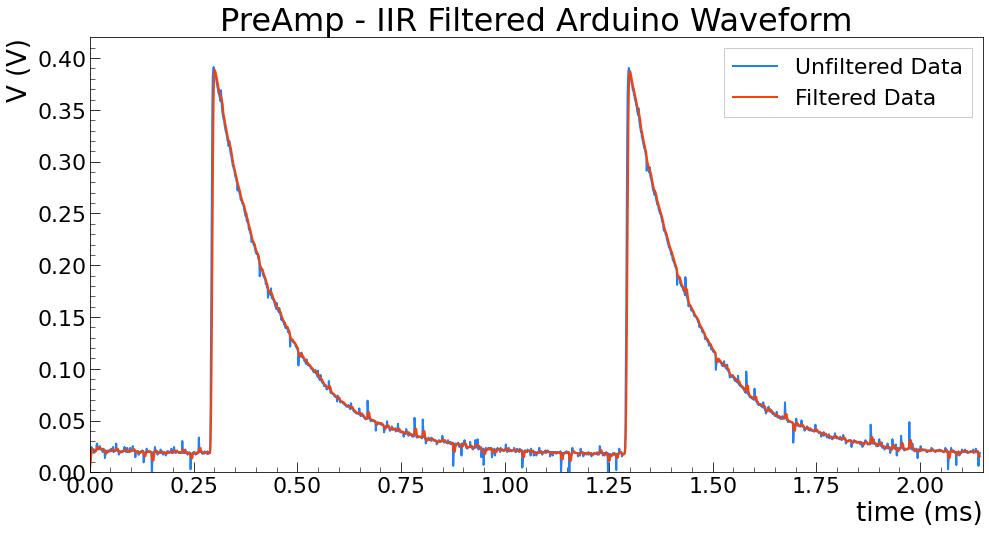

In [386]:
NR.arduino_waveform_IIR_filter(data)

So far so good. Let's take a closer look at the first peek.

In [457]:
# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek_IIR = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

data_peek_IIR

,time,ADC,time (ms),V (V),err V (V),V filter
287,287,1237,0.300524,0.388095,0.009805,0.387929
288,288,1233,0.301571,0.384782,0.009805,0.388426
289,289,1231,0.302618,0.383125,0.009805,0.387267
290,290,1231,0.303665,0.383125,0.009805,0.385610
291,291,1226,0.304712,0.378983,0.009805,0.383622
...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.011540
1196,1196,789,1.252356,0.017007,0.009805,0.011208
1197,1197,790,1.253403,0.017835,0.009805,0.015350
1198,1198,789,1.254450,0.017007,0.009805,0.016841


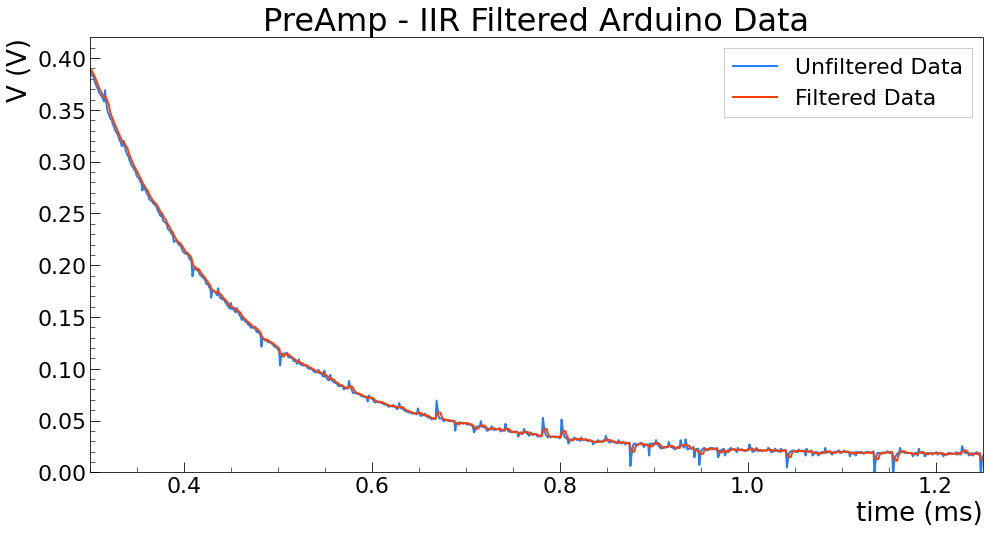

In [458]:
NR.arduino_waveform_IIR_filter_peek(data_peek_IIR)

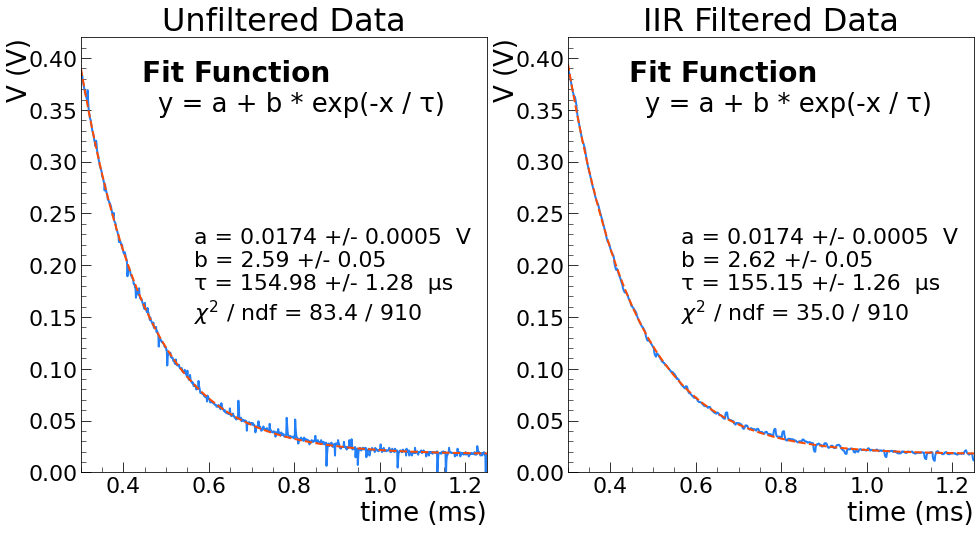

In [459]:
NR.arduino_IIR_exp_fit(data_peek_IIR)

Great results! Data still looks kind of noisy though: let's see if we can do better!

## Noise Reduction: 2nd attempt

### Apply a Butterworth filter to data

I'd like to use a moving average filter but, as it is technically a low-pass filter, it is just easier to apply a low pass filter.

In [461]:
# Desing the Butterworth filter
N  = 3    # Filter order
Wn = 0.1  # Cutoff frequency (normalized)
B, A = signal.butter(N, Wn, output = 'ba')

# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek_butter = data_peek

# WE APPLY THE FILTER JUST TO THE FIRST PEEK FOR BETTER RESULTS
data_peek_butter['V filter2'] = signal.filtfilt(B, A, data_peek_butter['V (V)'])

data_peek_butter

,time,ADC,time (ms),V (V),err V (V),V filter2
287,287,1237,0.300524,0.388095,0.009805,0.387999
288,288,1233,0.301571,0.384782,0.009805,0.385580
289,289,1231,0.302618,0.383125,0.009805,0.383212
290,290,1231,0.303665,0.383125,0.009805,0.380910
291,291,1226,0.304712,0.378983,0.009805,0.378684
...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.014159
1196,1196,789,1.252356,0.017007,0.009805,0.014314
1197,1197,790,1.253403,0.017835,0.009805,0.014536
1198,1198,789,1.254450,0.017007,0.009805,0.014808


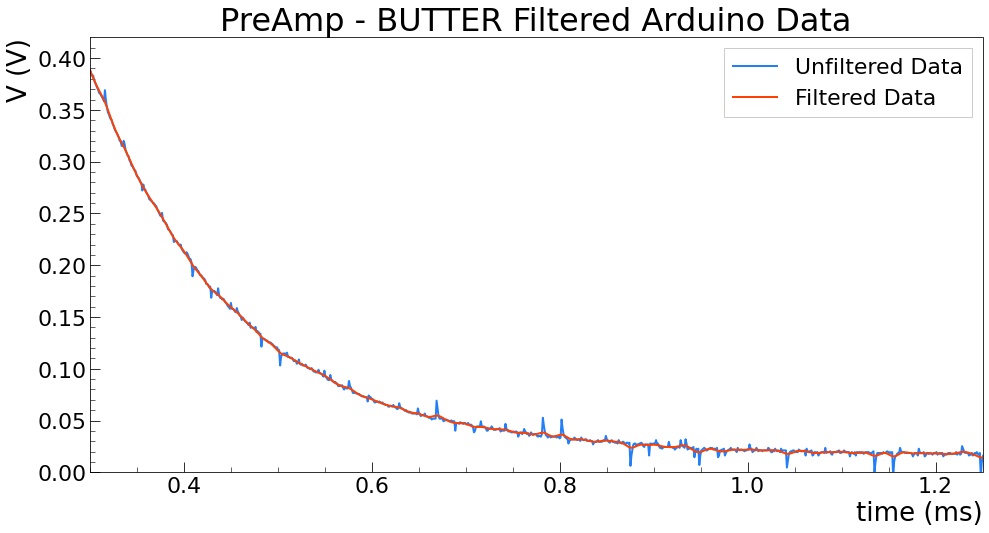

In [462]:
NR.arduino_waveform_BUTTER_filter_peek(data_peek_butter)

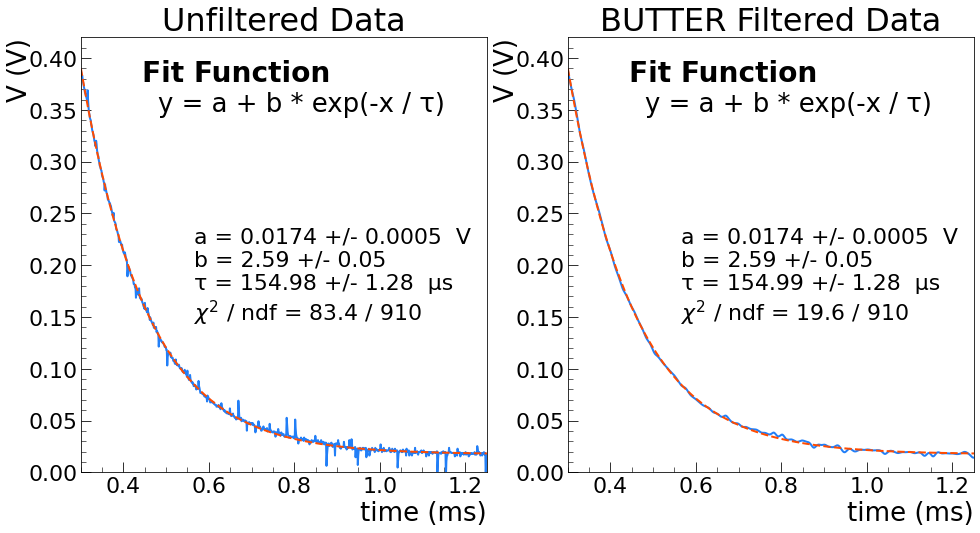

In [463]:
NR.arduino_BUTTER_exp_fit(data_peek_butter)

As we can see, the fit gets really better now! Data is way less noisy than before. 

## Linearized Fit

The main reason we want a noise-clear data is linearization: noisy data is, in fact, way harder to linearize. Here an example of unfiltered linearized data:

In [464]:
# Normalize data by subtracting the exponential fit offset a 
data_peek['normV'] = data_peek['V (V)'] - NR.unfiltered_exp_offset

# Drop all negative values
data_peek = data_peek[(data_peek['normV'] > 0)]

# Error propagation on the difference
data_peek['err normV'] = np.sqrt(data_peek['err V (V)']**2 + NR.unfiltered_exp_offset_err**2)

# Take the natural logarithm 
data_peek['logV'] = np.log(data_peek['normV'])

# Error propagation on the logarithm
data_peek['err logV'] = data_peek['err normV'] / data_peek['normV']

# Drop data with huge uncertainty as it is not significative 
data_peek = data_peek[(data_peek['err logV'] < 1)] 
data_peek

,time,ADC,time (ms),V (V),err V (V),V filter2,normV,err normV,logV,err logV
287,287,1237,0.300524,0.388095,0.009805,0.387999,0.370681,0.00982,-0.992412,0.026492
288,288,1233,0.301571,0.384782,0.009805,0.385580,0.367368,0.00982,-1.001391,0.026731
289,289,1231,0.302618,0.383125,0.009805,0.383212,0.365712,0.00982,-1.005910,0.026852
290,290,1231,0.303665,0.383125,0.009805,0.380910,0.365712,0.00982,-1.005910,0.026852
291,291,1226,0.304712,0.378983,0.009805,0.378684,0.361570,0.00982,-1.017300,0.027159
...,...,...,...,...,...,...,...,...,...,...
864,864,802,0.904712,0.027775,0.009805,0.026147,0.010361,0.00982,-4.569672,0.947749
875,875,804,0.916230,0.029432,0.009805,0.024377,0.012018,0.00982,-4.421350,0.817105
887,887,806,0.928796,0.031088,0.009805,0.025753,0.013675,0.00982,-4.292212,0.718115
892,892,807,0.934031,0.031916,0.009805,0.025701,0.014503,0.00982,-4.233402,0.677100


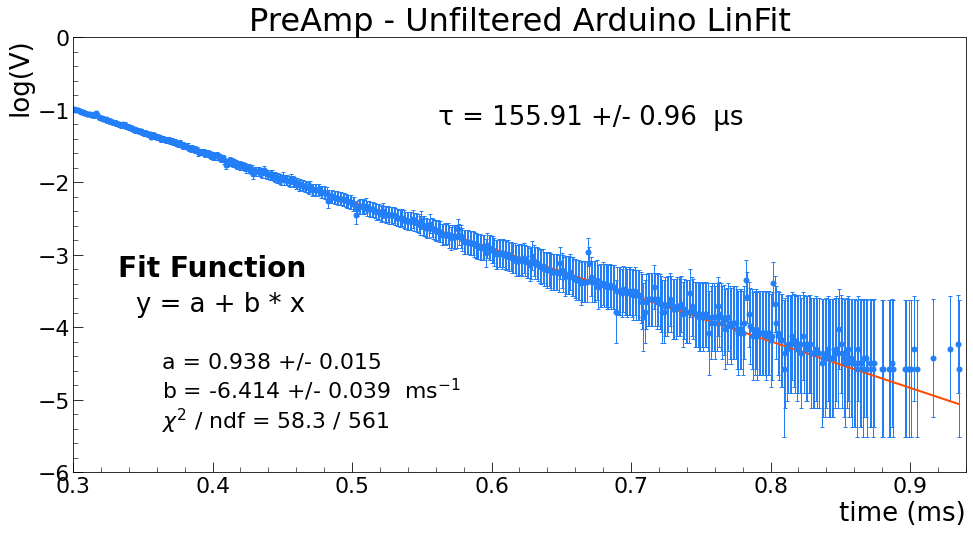

In [481]:
NR.arduino_lin_fit(data_peek)

Even though the results are not _that_ bad, the fit does not satisfy _that_ much. Let's point out that most of the data points have been removed due to **huge** uncertainty: normalizing data with the offset of the exponential fit leads most of the tail-data really close to zero. The error propagation on the logarithm of such points results in a exaggerated uncertainty. Moreover, the noise is hard to normalize thus we still have a non-linear tail!

### Linearized Butterworth Filter

In [467]:
# Normalize data by subtracting the exponential fit offset a 
data_peek_butter['normV filter'] = data_peek_butter['V filter2'] - NR.butter_exp_offset

# Drop all negative values
data_peek_butter = data_peek_butter[(data_peek_butter['normV filter'] > 0)]

# Error propagation on the difference
data_peek_butter['err normV filter'] = np.sqrt(data_peek_butter['err V (V)']**2 + NR.butter_exp_offset_err**2)

# Take the natural logarithm 
data_peek_butter['logV filter'] = np.log(data_peek_butter['normV filter'])

# Error propagation on the logarithm
data_peek_butter['err logV filter'] = data_peek_butter['err normV filter'] / data_peek_butter['normV filter']

# Drop data with huge uncertainty as it is not significative 
data_peek_butter = data_peek_butter[(data_peek_butter['err logV filter'] < 1)] 
data_peek_butter

,time,ADC,time (ms),V (V),err V (V),V filter2,normV,normV filter,err normV filter,logV filter,err logV filter
287,287,1237,0.300524,0.388095,0.009805,0.387999,0.370681,0.370595,0.00982,-0.992645,0.026498
288,288,1233,0.301571,0.384782,0.009805,0.385580,0.367368,0.368176,0.00982,-0.999194,0.026672
289,289,1231,0.302618,0.383125,0.009805,0.383212,0.365712,0.365808,0.00982,-1.005646,0.026845
290,290,1231,0.303665,0.383125,0.009805,0.380910,0.365712,0.363506,0.00982,-1.011960,0.027015
291,291,1226,0.304712,0.378983,0.009805,0.378684,0.361570,0.361280,0.00982,-1.018103,0.027181
...,...,...,...,...,...,...,...,...,...,...,...
825,825,803,0.863874,0.028603,0.009805,0.028977,0.011190,0.011573,0.00982,-4.459054,0.848501
826,826,803,0.864921,0.028603,0.009805,0.028739,0.011190,0.011335,0.00982,-4.479865,0.866345
827,827,802,0.865969,0.027775,0.009805,0.028427,0.010361,0.011023,0.00982,-4.507764,0.890855
828,828,804,0.867016,0.029432,0.009805,0.028033,0.012018,0.010629,0.00982,-4.544134,0.923851


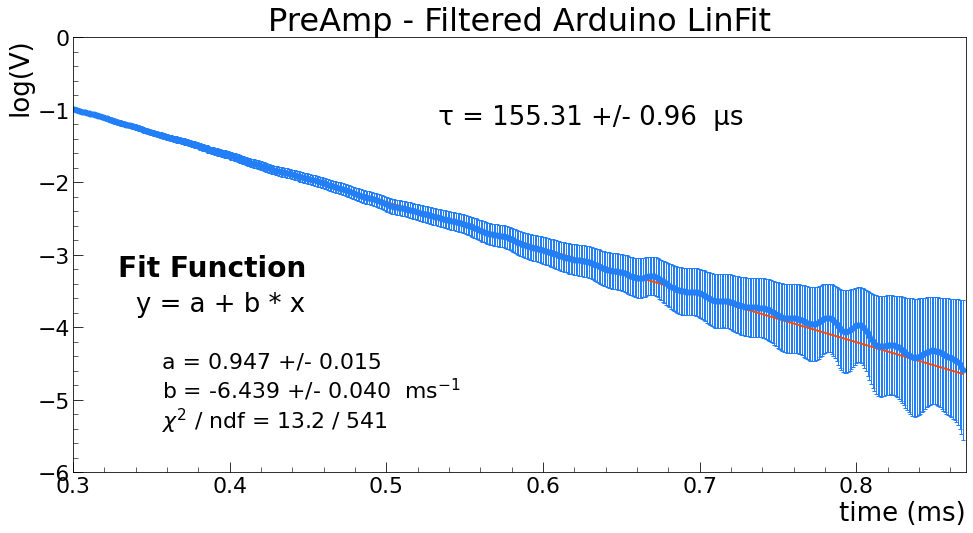

In [480]:
NR.arduino_butter_lin_fit(data_peek_butter)

In [479]:
importlib.reload(NR)

<module 'Arduino_NoiseReduction_Code' from 'd:\\GitHub\\physics_laboratory_2020_2021\\CATENA ELETTRONICA\\Python\\Arduino_NoiseReduction_Code.py'>

## Moving Average

In [534]:
# READ DATA FROM FILE
file_name = '../Data/PreAmp/data_arduino.dat'

data = pd.read_csv(file_name, index_col = False, header = None, sep = ' ')
data.index = np.arange(1, len(data)+1)

data.columns = ['time', 'ADC']

# CALIBRATION
SAMPLING = 955000

data['time (ms)'] = data['time'] * 1e3 * SAMPLING**-1
data['V (V)']  = arduino_calib_offset + arduino_calib_slope * data['ADC']
data['err V (V)'] = np.sqrt(arduino_calib_offset_err**2 + arduino_calib_slope_err**2)

# PRINT DATA
data

,time,ADC,time (ms),V (V),err V (V)
1,1,795,0.001047,0.021977,0.009805
2,2,793,0.002094,0.020320,0.009805
3,3,793,0.003141,0.020320,0.009805
4,4,798,0.004188,0.024462,0.009805
5,5,795,0.005236,0.021977,0.009805
...,...,...,...,...,...
2043,2043,793,2.139267,0.020320,0.009805
2044,2044,776,2.140314,0.006239,0.009805
2045,2045,787,2.141361,0.015350,0.009805
2046,2046,788,2.142408,0.016178,0.009805


In [535]:
# LET'S ANALIZE JUST THE FIRST PEEK OF THE DATA
data_peek = data.loc[(data['time (ms)'] > 0.3) & (data['time'] < 1200 )]

# WINDOW
WND = 1

# TAKE THE MOVING AVERAGE
data_peek['AVG'] = data_peek['V (V)'].rolling(window=WND).mean()

# COMPUTER MEAN ERROR
data_peek['err AVG'] = data_peek['err V (V)'] / np.sqrt(WND)

# DROP NAN ROWS
data_peek = data_peek[data_peek['AVG'].notna()]

# PRINT DATA
data_peek

,time,ADC,time (ms),V (V),err V (V),AVG,err AVG
287,287,1237,0.300524,0.388095,0.009805,0.388095,0.009805
288,288,1233,0.301571,0.384782,0.009805,0.384782,0.009805
289,289,1231,0.302618,0.383125,0.009805,0.383125,0.009805
290,290,1231,0.303665,0.383125,0.009805,0.383125,0.009805
291,291,1226,0.304712,0.378983,0.009805,0.378983,0.009805
...,...,...,...,...,...,...,...
1195,1195,789,1.251309,0.017007,0.009805,0.017007,0.009805
1196,1196,789,1.252356,0.017007,0.009805,0.017007,0.009805
1197,1197,790,1.253403,0.017835,0.009805,0.017835,0.009805
1198,1198,789,1.254450,0.017007,0.009805,0.017007,0.009805


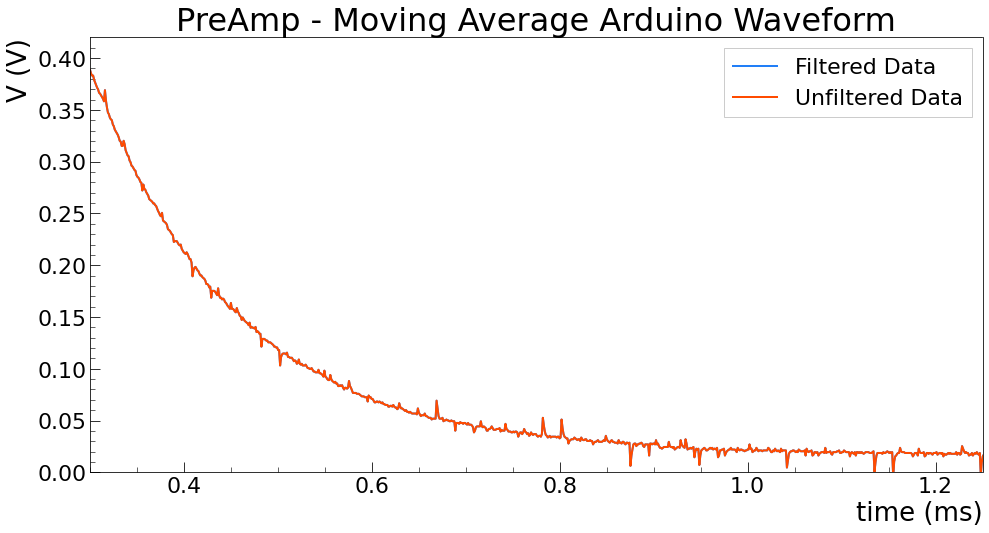

In [536]:
# FIG SETTINGS AND AXES
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(data_peek['time (ms)'], data_peek['V (V)'], color = '#227FF7', linewidth = 2, marker = '.', markersize = 0, label = 'Filtered Data')
ax1.plot(data_peek['time (ms)'], data_peek['AVG'], color = '#FF4B00', linewidth = 2, marker = '.', markersize = 0, label = 'Unfiltered Data')

# PLOT TITLE
ax1.set_title('PreAmp - Moving Average Arduino Waveform', fontsize = 32)
# AXIS LABELS
ax1.set_xlabel('time (ms)', fontsize = 26, loc = 'right')
ax1.set_ylabel('V (V)', fontsize = 26, loc = 'top')
# AXIS TICKS
ax1.tick_params(axis = 'both', which = 'major', labelsize = 22, direction = 'in', length = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 22, direction = 'in', length = 5)
ax1.set_xticks(ticks = ax1.get_xticks(), minor = True)
ax1.set_yticks(ticks = ax1.get_yticks(), minor = True)
ax1.minorticks_on()
# PLOT RANGE
ax1.set_xlim(left = 0.3, right = 1.25)
ax1.set_ylim(bottom = 0, top = 0.42)
ax1.legend(loc = 'upper right', prop = {'size': 22}, ncol = 1, frameon = True, fancybox = False, framealpha = 1)

plt.show()